<a href="https://colab.research.google.com/github/muGithub/Python/blob/master/DRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
a:-1.0
edsl:0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
edsl:0.0
r:0.0
a:-1.0
ed

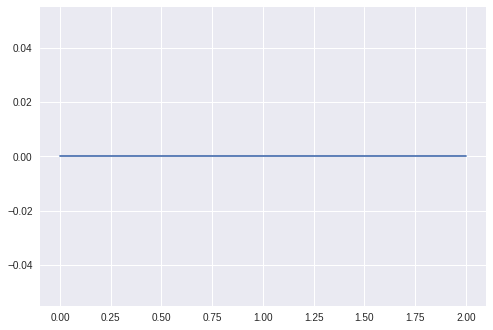

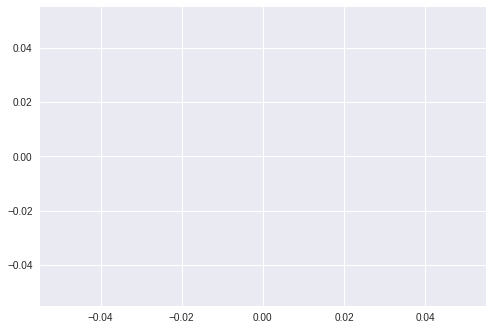

In [0]:
import numpy as np
import tensorflow as tf
from Target_Ego_MDP import Target_Ego
import Target_Ego_MDP
import math
from matplotlib import pyplot as plt
#####################  hyper parameters  ####################

MAX_STEPS = 1000
K_EPISODES = 3
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_SIZE = 500
BATCH_SIZE = 32
ALPHA = 0.1


class AGC_DRL(object):
    def __init__(self,a_dim, s_dim,):
        self.a_dim = a_dim
        self.s_dim = s_dim

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((MEMORY_SIZE, self.s_dim * 2 + self.a_dim* 2))
        self.memory_counter = 0
        self.sess = tf.Session()
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        with tf.variable_scope('Actor'):
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            self.q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        # networks parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # target net replacement
        self.soft_replace = [tf.assign(t, (1 - TAU) * t + TAU * e)
                             for t, e in zip(self.at_params + self.ct_params, self.ae_params + self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=self.q)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=self.ce_params)

        a_loss = - tf.reduce_mean(self.q)  # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        self.sess.run(tf.global_variables_initializer())

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, r, s_))
        # replace the old memory with new memory
        index = self.memory_counter%MEMORY_SIZE
        self.memory[index,:] = transition
        self.memory_counter += 1

    def choose_action(self, s):
        s = np.array(s)
        a = self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]
        if a< -2:
            a = -2
        elif a > 2:
            a = 2
        return a

    def max_q_action(self, s, a_list):
        max_q = -np.inf
        max_q_a = 0
        s = np.array(s)
        for a in a_list:
            a = np.array([a])
            q = self.sess.run(self.q, {self.S: s[np.newaxis, :], self.a: a[np.newaxis, :]})
            if q > max_q:
                max_q = q
                max_q_a = a
        return max_q_a

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)
        indices = np.random.choice(MEMORY_SIZE, size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            net = tf.layers.dense(s, 30, activation=tf.nn.relu, name='l1', trainable=trainable)
            a = tf.layers.dense(net, self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)
            return tf.multiply(a, 1, name='scaled_a')

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            return tf.layers.dense(net, 1, trainable=trainable)  # Q(s,a)

###############################  training  ####################################

DDPG = AGC_DRL(a_dim=1, s_dim=6, )
# List every Task'mean reward
E_Totall_R = 0
V = []
E_S = []
for t in range(Target_Ego_MDP.TASK_NUM):
    env = Target_Ego(task_num=t)
    s = env.reset(task_num=t)
    for i in range(MAX_STEPS):
        if env.IsCrash or env.done:
            s = env.reset(task_num=t)
        a = DDPG.choose_action(s)[0]
        print('a:%s'% a)
        print('edsl:%s'% env.edsl)
        r = env.get_env_feedback(a)
        print('r:%s' % r)
        s_ = env.E_choose_state(a)
        DDPG.store_transition(s, a, r, s_)
        if DDPG.memory_counter > MEMORY_SIZE:
            DDPG.learn()
        s = s_
        E_Totall_R += r
    V.append(E_Totall_R/MAX_STEPS)
# select ith task
Dict = {}
Success_Rates = []
Event_Num = 0
Success_Num = 0

for k in range(K_EPISODES):
    Ve = [math.exp(v) for v in V]
    P = [ve/sum(Ve) for ve in Ve]
    RP = np.random.ranf()
    _P = [sum(P[:n]) for n in range(1, len(P) + 1)]
    t = 0
    for idx in range(len(_P)):
        if RP < _P[idx]:
            t = idx
            print('第%d次迭代选择了第%d个任务'%(k,t))
            break
    # selected task id = t
    env = Target_Ego(task_num=t)
    s = env.reset(task_num=t)
    # training DDPG network
    for i in range(MAX_STEPS):
        if env.IsCrash or env.done:
            Event_Num += 1
            if env.done:
                E_S.append(env.edsl)
                Success_Num += 1
            s = env.reset(task_num=t)
        a = DDPG.choose_action(s)[0]
        r = env.get_env_feedback(a)
        s_ = env.E_choose_state(a)
        DDPG.store_transition(s, a, r, s_)
        if DDPG.memory_counter > MEMORY_SIZE:
            DDPG.learn()
        s = s_
    for t_idx in range(Target_Ego_MDP.TASK_NUM):
        t_env = Target_Ego(task_num=t_idx)
        t_s = t_env.reset(task_num=t_idx)
        t_E_Totall_R = 0
        for i in range(MAX_STEPS):
            if t_env.IsCrash or t_env.done:
                Event_Num += 1
                if env.done:
                    E_S.append(env.edsl)
                    Success_Num += 1
                t_s = t_env.reset(task_num=t_idx)
            t_a = DDPG.max_q_action(t_s, t_env.sample_a(100, -3, 2))[0]
            t_r = t_env.get_env_feedback(t_a)
            t_s_ = t_env.E_choose_state(t_a)
            t_s = t_s_
            t_E_Totall_R += t_r
        Mean_R = t_E_Totall_R/MAX_STEPS
        print('第%d个任务的平均Reward是%s' % (t_idx, Mean_R))
        if t_idx not in Dict:
            Dict[t_idx] = [Mean_R]
        else:
            Dict[t_idx].append(Mean_R)
        print(Dict)
        # update every task V value
        V[t_idx] = ALPHA*(t_E_Totall_R/MAX_STEPS) + (1-ALPHA)*V[t_idx]

    Success_Rates.append(Success_Num / Event_Num)

plt.plot([k for k in range(K_EPISODES)], Success_Rates)
plt.show()
plt.plot([j for j in range(len(E_S))], E_S)
plt.show()
